# Tumour Detection/Classification Using MRI Data
Dataset from Github repository: https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet

# Project Overview & Objectives

The aim of this project is to create a convolutional neural network using PyTorch that can detect and classify whether a person has a brain tumor based on an MRI scan. The classification is into one of four options: 

### No Tumor

These are self explanatory, simply MRI scans of brains that posses no tumors. 

### Glioma Tumor

Glioma tumors can be both cancerous and non-cancerous. They start in the supporting cells (glial cells) of the brain and spinal cord. A lof of glioma tumors are diffuse; they don't have a clear boundary between tumor and normal brain tissue. This could pose an issue for our classification process. 

(Information based on https://www.cancerresearchuk.org/about-cancer/brain-tumours/types/glioma-adults)

### Meningioma Tumor

Meningioma tumors tend to be non-cancerous, although can be cancerous. They start in the layers of tissue that cover the brain and spine (meninges). It is common to test for these tumors using MRI scans, and so we should expect our model to be reasonably accurate in classifying these.

(Information based on https://www.cancerresearchuk.org/about-cancer/brain-tumours/types/meningioma)

### Pituitary Tumor

Pituitary tumors tend to be non-cancerous, although can be cancerous. They start to grow in the pituitary glad. It is common to test for these tumors using MRI scans, and so we should expect our model to be reasonably accurate in classifying these.

(Information based on https://www.cancerresearchuk.org/about-cancer/brain-tumours/types/pituitary-tumours)

## Outputs & Metrics

In order to train our model, we will make use of the Cross Entropy Loss function, a popular loss function for classification problems. Along with the losses, we will also display the accuracy of the model. This is calculated simply as 

\begin{equation}
    \text{accuracy} = \frac{\text{Number of correctly classified images}}{\text{Total number of images}}
\end{equation}

and ranges from $(0,1)$, with $0$ meaning no image labels were correctly predicted, and $1$ meaning a perfect model.

As accuracy only measures the total correct vs incorrect classifications, it will not allow us to see where these errors are made. In particular, for this problem it is important to know when someone is labelled as "no_tumor" when in reality they have a tumor (of any kind). For this reason, we also display the confusion matrix for our test data, to get deeper insight into this. Note, as mentioned above, we can expect the glioma classification to perform the worst.

# Setting up the code

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import numpy as np
import glob 
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.model_selection import train_test_split
import cv2 
import random 
import seaborn as sns 

# Load in the data 

In [2]:
tumor_types = ["glioma_tumor", "meningioma_tumor", "pituitary_tumor"]
IMG_SIZE = 150

In [3]:
class MRI(Dataset):
    def __init__(self,training_or_testing):
        
        # Allowing for class to account for both training and testing 
        if training_or_testing == "Training" or training_or_testing == "Testing":
            
            if training_or_testing == "Training":
                self.mode = "train"
            else:
                self.mode = "test"
            
            # Loading in the data

            imgs = []
            imgs_reshaped = []
            labels = []
            path = (f"./Data/{training_or_testing}")

            # First the positive tumor cases
            for t in tumor_types:
                for f in glob.iglob(path + "/" + t + "/*.jpg"):
                    img = cv2.imread(f)
                    img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
                    b, g, r = cv2.split(img)
                    img = cv2.merge([r,g,b])
                    imgs.append(img)
                    img = img.reshape((img.shape[2], img.shape[0], img.shape[1])) 
                    imgs_reshaped.append(img)
                    labels.append(t)

            # Then the negative tumor cases
            for f in glob.iglob(path + "/no_tumor/*.jpg"):
                img = cv2.imread(f)
                img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
                b, g, r = cv2.split(img)
                img = cv2.merge([r,g,b])
                imgs.append(img)
                img = img.reshape((img.shape[2], img.shape[0], img.shape[1])) 
                imgs_reshaped.append(img)
                labels.append("no_tumor")

            # Manual "one-hot encode" training labels
            labels_encoded = [0 if t_type == "no_tumor" 
                                        else(1 if t_type == "glioma_tumor" 
                                        else(2 if t_type == "meningioma_tumor" 
                                        else 3)) 
                                        for t_type in labels]

            # Convert to np array and assign
            self.imgs = np.array(imgs)
            self.imgs_reshaped = np.array(imgs_reshaped, dtype = np.float32)
            self.labels = np.array(labels)
            self.labels_encoded = np.array(labels_encoded)
            self.X_train = np.array(imgs_reshaped, dtype = np.float32)
            self.y_train = np.array(labels_encoded)
            self.X_val = None 
            self.y_val = None 
            
    def train_val_split(self, test_size):
        """
        Returns sk_learn train_test_split for a (train,validation) split based on test_size input. 
        """
        if self.mode == "train":
            self.X_train, self.X_val, self.y_train, self.y_val = \
            train_test_split(self.imgs_reshaped, self.labels_encoded, test_size=test_size, random_state=42)

        elif self.mode == "test": 
            print("You don't want to split the test data")
            
    def __len__(self):
        """
        Return the number of images in the data, depending on mode (test, train, val)
        """
        if self.mode == "test":
            return self.imgs.shape[0]
        elif self.mode == "train":
            return self.X_train.shape[0]
        elif self.mode == "val":
            return self.X_val.shape[0]
        else: 
            print('Invalid self.mode. Options "test", "train", "val".')
    
    def __getitem__(self,idx):
        """
        Returns dictionary containing the image and label at index = idx
        """
        if self.mode == "test":
            return self.imgs_reshaped[idx], self.labels_encoded[idx] 
        elif self.mode == "train":
            return self.X_train[idx], self.y_train[idx]
        elif self.mode == "val":
            return self.X_val[idx], self.y_val[idx]
        else: 
            print('Invalid self.mode. Options "test", "train", "val".')
    
    def normalise(self):
        """
        Normalises the images to lie in range (0,1)
        """
        self.imgs = self.imgs/255.0
        self.imgs_reshaped = self.imgs_reshaped/255.0
        return None 
        

In [4]:
# Create training data and test data instances
training_data = MRI("Training")
training_data.normalise()
test_data = MRI("Testing")
test_data.normalise()

# Visulisations

In [5]:
# Define function for giving us num random MRI images with their labels 

def plot_random_MRI(data, labels, num=5):
    idx = np.random.choice(data.shape[0], num, replace=False)
    imgs = data[idx]
    label = []
    for i in idx.tolist():
        label.append(labels[i])
    
    plt.figure(figsize=(20,20))
    for j in range(num):
        plt.subplot(1,num, j+1)
        plt.title(label[j])
        plt.imshow(imgs[j]) 

### Look at some training data

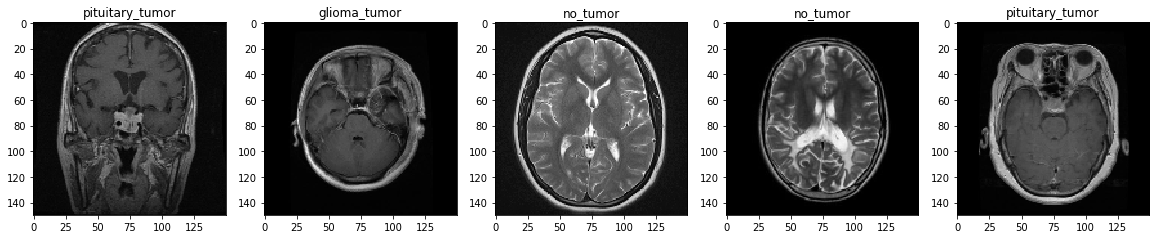

In [26]:
plot_random_MRI(training_data.imgs, training_data.labels)

### Look at distribution of data within training and test

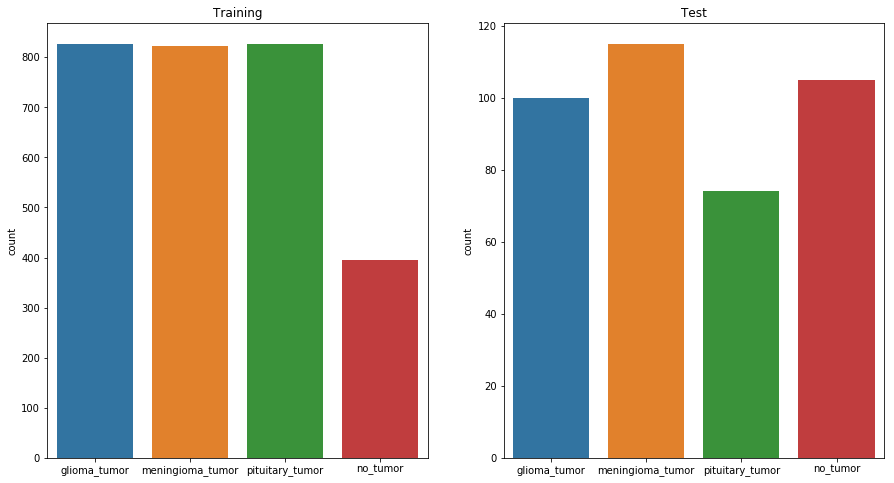

In [8]:
plt.figure(figsize=(15,8))
l = ["Training", "Test"]
for i,lab in enumerate([training_data.labels, test_data.labels]):
    plt.subplot(1,2,i+1)
    sns.countplot(x = lab)
    plt.title(l[i])

### Comment:
Although the training data has less no_tumor cases, the test data has quite a few. This will be good for checking to see if the algorithm actually understands tumor vs no_tumor. 

# Preparing Data For Training

## Split training data in train and validation 

In [9]:
training_data.train_val_split(0.2)
print("Training data has shapes", training_data.X_train.shape, training_data.y_train.shape)
print("Validation data has shapes", training_data.X_val.shape, training_data.y_val.shape)

Training data has shapes (2296, 3, 150, 150) (2296,)
Validation data has shapes (574, 3, 150, 150) (574,)


## Load the three data types.

In [27]:
# Shuffle only needed for training, as validation and test will only be evaluated

train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
val_loader = DataLoader(training_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Creating CNN 

We define a simple convolutional neural network and feed it into a simple linear model with 4 outputs (our tumor categories) 

Note: the dimension of the output of each step in cnn_model is given by 

\begin{equation}
    n_{out} =  \text{floor}\bigg( \frac{n_{in} + 2p - k}{s} + 1\bigg)
\end{equation}

where $p$ is the padding, $k$ the kernel_size and $s$ the stride. As we are using $s=1$ and $2p-k+1$, we simply get $n_{out} = n_{in}$.

This is true for every layer APART from the MaxPool2d layer as, by default, $s=k$ unless otherwise specified. So at the MaxPool2d layer we go from $n_{in} = 150$ (i.e. IMG_SIZE) to $n_{out} = 75$. This is where the in_features $=75*75*32$ comes from for the fc_model.

In [11]:
class CNN(nn.Module):
    def __init__(self, channel1 = 15, channel2 = 25):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=channel1 , kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=channel1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=channel1, out_channels=channel2, kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=channel2, out_channels=32, kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU()
        )
        
        self.fc_model = nn.Sequential(
            nn.Linear(in_features=75*75*32, out_features=4)
        )
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(-1, 32*75*75) 
        x = self.fc_model(x)
        return x

# Training & Validating 

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# The model can take in two integers that are the channels of the CNN. By default they are (15,25).
model = CNN().to(device)

# Comment: my computer won't allow cuda, so the below code has been written assuming device = cpu. 
# Some modifications would need to be made for cuda, e.g. sending the tensors for images and labels to cuda device.

optimizer = Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function = nn.CrossEntropyLoss()

best_accuracy=0.0
epoch_train_loss = []
epoch_val_loss = []
train_accs = []
val_accs = []

print("Training is running on the", device.type)

for epoch in range(15):
    
    #Evaluation and training on training dataset
    model.train()
    training_data.mode = "train"
    
    train_correct = 0.0
    train_count = 0.0
    train_losses = []
    
    for images,labels in train_loader:
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        _,pred=torch.max(outputs.data,1)
        
        if labels.data.shape == pred.shape:
            train_count += int(pred.shape[0])
            train_correct += int(torch.sum(pred==labels.data))
        
    train_accuracy = train_correct/train_count
    train_accs.append(train_accuracy)
    epoch_train_loss.append(np.mean(train_losses))
    
    
    # Evaluation on testing dataset
    model.eval()
    training_data.mode = "val"
    val_losses = []
    val_correct = 0.0
    val_count = 0.0
    
    with torch.no_grad():
        for images,labels in val_loader:

            outputs=model(images)
            
            loss=loss_function(outputs,labels)
            val_losses.append(loss.item())
            
            _,pred=torch.max(outputs.data,1)

            if labels.data.shape == pred.shape:
                val_count += int(pred.shape[0])
                val_correct += int(torch.sum(pred == labels.data))
    
    val_accuracy = val_correct/val_count
    val_accs.append(val_accuracy)
    epoch_val_loss.append(np.mean(val_losses))
    
    
    print('Epoch:', epoch+1)
    print(' Train Loss:', np.mean(train_losses), ' Train Accuracy:', train_accuracy)
    print(' Validation Loss:', np.mean(val_losses), ' Validation Accuracy:', val_accuracy)
    print("-"*10)
    
    if val_accuracy>best_accuracy:
        best_accuracy=val_accuracy
        best_epoch = epoch+1
        
print("-"*30)
print("Training complete")
print(f"The best validation accuracy was {best_accuracy} in epoch {best_epoch}")

Training is running on the cpu
Epoch: 1
 Train Loss: 8.414344958133167  Train Accuracy: 0.5844947735191638
 Validation Loss: 18.924259821573894  Validation Accuracy: 0.5679442508710801
----------
Epoch: 2
 Train Loss: 2.99505209726178  Train Accuracy: 0.7591463414634146
 Validation Loss: 10.44286674923367  Validation Accuracy: 0.6027874564459931
----------
Epoch: 3
 Train Loss: 1.6090212814095948  Train Accuracy: 0.8109756097560976
 Validation Loss: 2.48836651775572  Validation Accuracy: 0.7560975609756098
----------
Epoch: 4
 Train Loss: 0.8904933486095009  Train Accuracy: 0.8915505226480837
 Validation Loss: 1.6765915122297075  Validation Accuracy: 0.8013937282229965
----------
Epoch: 5
 Train Loss: 0.4503236706069502  Train Accuracy: 0.9198606271777003
 Validation Loss: 2.0603875848982067  Validation Accuracy: 0.764808362369338
----------
Epoch: 6
 Train Loss: 0.22787228117338523  Train Accuracy: 0.9542682926829268
 Validation Loss: 2.0350498391522303  Validation Accuracy: 0.7787456

## Plot the results

Text(0, 0.5, 'Loss')

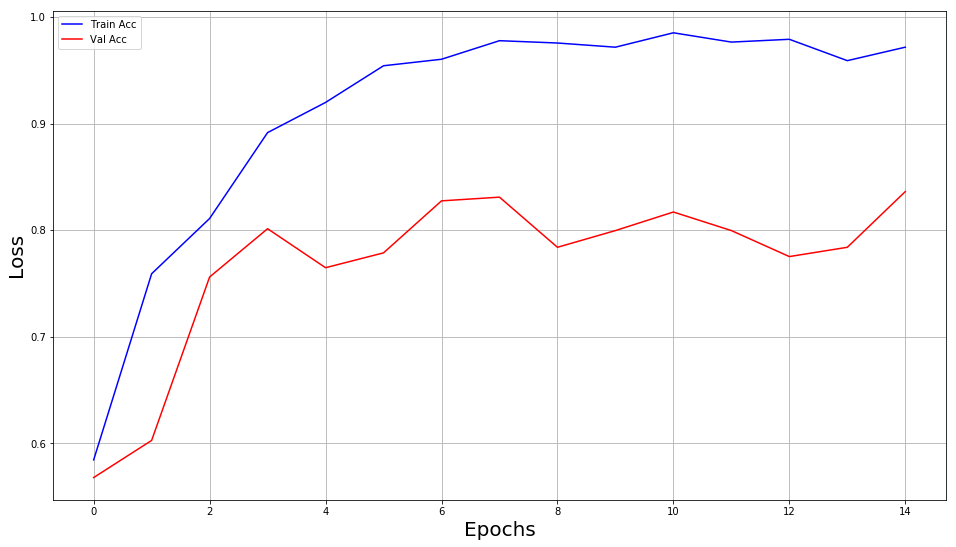

In [13]:
plt.figure(figsize=(16,9))
plt.plot(train_accs, c='b', label='Train Acc')
plt.plot(val_accs, c='r', label = 'Val Acc')
plt.legend()
plt.grid()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)

Text(0, 0.5, 'Loss')

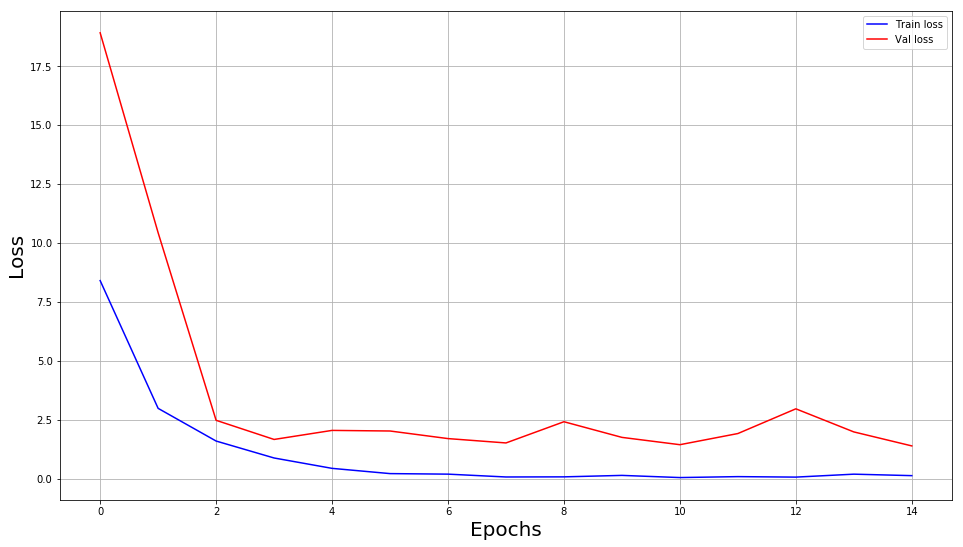

In [14]:
plt.figure(figsize=(16,9))
plt.plot(epoch_train_loss, c='b', label='Train loss')
plt.plot(epoch_val_loss, c='r', label = 'Val loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)

## Look at confusion matrix

In [15]:
model.eval()
preds = []
y_true = []
with torch.no_grad():
    for image, label in test_loader:
        
        outputs = model(image)
        _,pred = torch.max(outputs.data,1)
        
        #print(pred)
        #print("lab",label)
        
        preds.append(pred)
        y_true.append(label.cpu().detach().numpy())
        
preds = np.concatenate( preds, axis=0 )
y_true = np.concatenate( y_true, axis=0 )

[Text(0, 0.5, 'no_tumor'),
 Text(0, 1.5, 'glioma_tumor'),
 Text(0, 2.5, 'meningioma_tumor'),
 Text(0, 3.5, 'pituitary_tumor')]

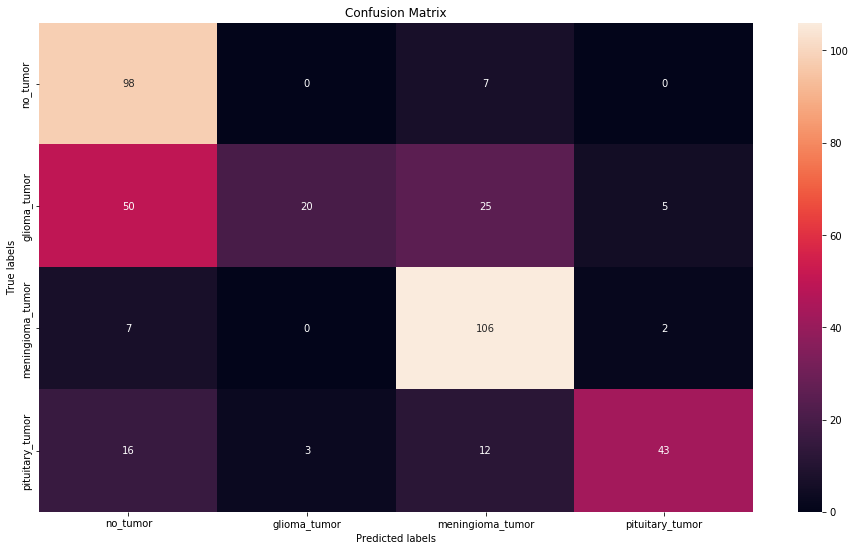

In [20]:
cm = confusion_matrix(y_true, preds)
plt.figure(figsize=(16,9))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(["no_tumor", "glioma_tumor", "meningioma_tumor", "pituitary_tumor"])
ax.yaxis.set_ticklabels(["no_tumor", "glioma_tumor", "meningioma_tumor", "pituitary_tumor"])

### Comments:

We see that the model performs reasonably well apart from the glioma tumors. We expected that this might be the case at the start. We can look at how the model performs on the validation set, to see if we are getting better results here.

In [21]:
model.eval()
preds_val = []
y_true_val = []
with torch.no_grad():
    for image, label in val_loader:
        
        outputs = model(image)
        _,pred = torch.max(outputs.data,1)
        
        #print(pred)
        #print("lab",label)
        
        preds_val.append(pred)
        y_true_val.append(label.cpu().detach().numpy())
        
preds_val = np.concatenate(preds_val, axis=0 )
y_true_val = np.concatenate(y_true_val, axis=0 )

[Text(0, 0.5, 'no_tumor'),
 Text(0, 1.5, 'glioma_tumor'),
 Text(0, 2.5, 'meningioma_tumor'),
 Text(0, 3.5, 'pituitary_tumor')]

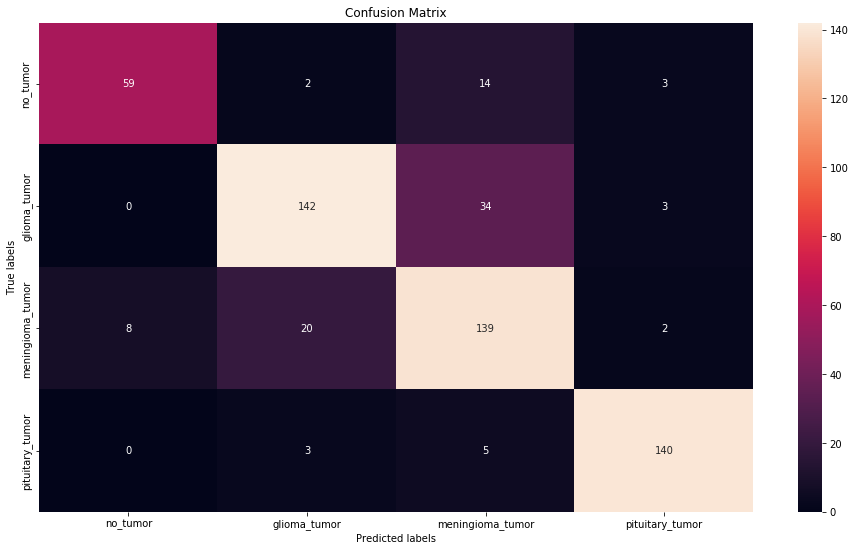

In [22]:
cm = confusion_matrix(y_true_val, preds_val)
plt.figure(figsize=(16,9))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(["no_tumor", "glioma_tumor", "meningioma_tumor", "pituitary_tumor"])
ax.yaxis.set_ticklabels(["no_tumor", "glioma_tumor", "meningioma_tumor", "pituitary_tumor"])

### Comments:
We get a significantly better performance on the validation data. This suggests that the model has developed an understanding of what it means for an MRI image to have an glioma tumor, and so warrants us looking at the data itself to see if this is the cause of the errors on the test data.

# Studying Glioma False Negatives
To try get a better understanding of the large amount of glioma_tumors classified as no_tumor in the test data, let's plot examples of each from both the test and training data.

In [23]:
def glioma_vs_no_examples(train_or_test, num=5):
    
    if train_or_test == "Training":
        data = training_data
    elif train_or_test == "Testing":
        data = test_data

    idx_glioma = []
    idx_no = []
    for i,lab in enumerate(data.labels):
        if lab == "glioma_tumor":
            idx_glioma.append(i)
        elif lab == "no_tumor":
            idx_no.append(i)
    
    imgs_glioma = data.imgs[idx_glioma]
    label_glioma = []
    for i in idx_glioma:
        label_glioma.append(data.labels[i])

    r_glioma = random.randint(0,len(label_glioma)-num)
    
    imgs_no = data.imgs[idx_no]
    label_no = []
    for i in idx_no:
        label_no.append(data.labels[i])

    r_no = random.randint(0,len(label_no)-num)
    
    plt.figure(figsize=(20,20))
    for j in range(num):
        plt.subplot(1,num, j+1)
        plt.title(f"{train_or_test}: No Tumor")
        plt.imshow(imgs_no[j+r_no]) 
        
    plt.figure(figsize=(20,20))
    for j in range(num):
        plt.subplot(1,num, j+1)
        plt.title(f"{train_or_test}: Glioma")
        plt.imshow(imgs_glioma[j+r_glioma]) 

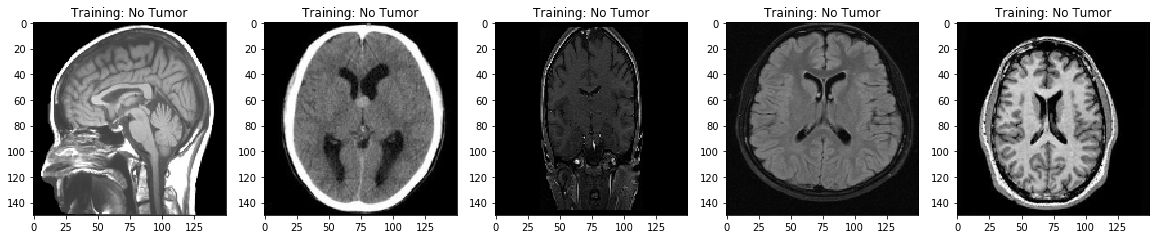

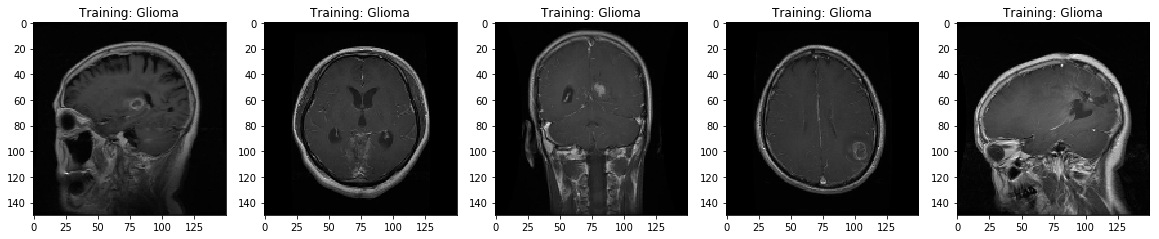

In [24]:
glioma_vs_no_examples("Training")

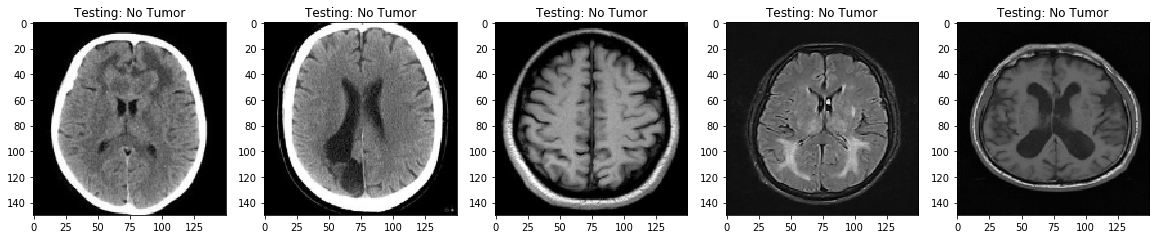

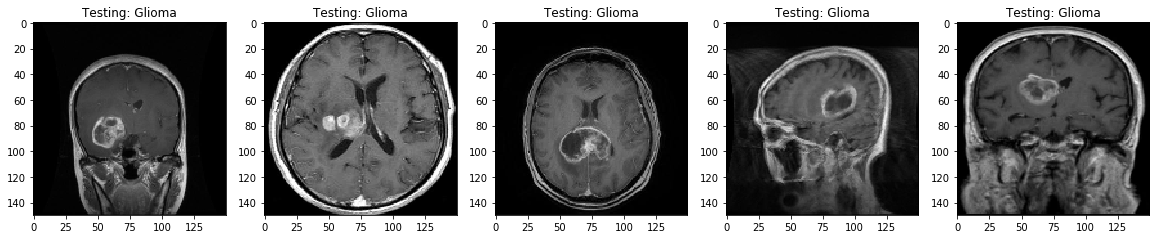

In [25]:
glioma_vs_no_examples("Testing")

### Comments:

It is reasonably clear that the test data glimoa images look significantly different to the training data equivalant. Additionally the training data glioma look comparible to the test no tumor examples, which supports the misclassification results above. 

# Improvments & Future Work

* In order to improve the model, it would be useful to use tools like FastAI to find the best hyperparameters to generate the best model.

* It would be interesting to import a pretrained model (using, e.g., HuggingFace) and then make use of hyperparameter tunning to optimise it for this dataset. 

* Further investigation is needed to be done to ensure we don't get false negatives.

* Writing a code that would highlight where the tumour in the brain is (along the lines of https://www.kaggle.com/code/ruslankl/brain-tumor-detection-v2-0-mask-r-cnn), would be of obvious advantage for practical use.

# References Used For Code

I have made use of two main references in designing this code, and the layout is based on their material. I will reference both below.

* https://www.kaggle.com/code/fahadmehfoooz/brain-tumor-detection-keras-pytorch/notebook

* https://www.youtube.com/watch?v=CiW8gS7kqOY&list=PL5foUFuneQnratPPuucpVxWl4RlqueP1u&index=1&ab_channel=MLDawn

